In [1]:
import numpy as np
import pandas as pd
from numpy import savez_compressed
import matplotlib.pyplot as plt
import os
import glob
from natsort import natsorted
from skimage.transform import rescale, resize, downscale_local_mean


os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

from tensorflow.keras.models import load_model

## Separation of Feature & Label 

In [3]:
path = os.path.abspath('../..')
VS_Pd_Rh = np.load(path+"/Step_1_train_test_data/VS_Pd_Rh.npy") 
VS_Pd_Rh.shape

(1314, 20, 64, 64)

In [4]:
X = np.zeros((VS_Pd_Rh.shape[0], 17, 3, 64, 64))
for i in range(17):
    X[:, i, :, :, :] = VS_Pd_Rh[:, i:i+3, :, :]
y = np.expand_dims(VS_Pd_Rh[:, 3:20, :, :], axis=2)  ## Takes frames from 4 to 20 one at a time, then repates these frames at 3rd dimension 3 times to match the size of X_train

X.shape, y.shape

((1314, 17, 3, 64, 64), (1314, 17, 1, 64, 64))

In [5]:
X = np.moveaxis(X, 2, -1)
y = np.moveaxis(y, 2, -1)

np.save(path+'/Step_1_train_test_data/X_y_feature_label/model_2/X_Pd_Rh.npy', X)
np.save(path+'/Step_1_train_test_data/X_y_feature_label/model_2/y_Pd_Rh.npy', y)

print(f'Pd-Rh set: Feature & Label Shape \n X: {str(X.shape)} \n y: { str(y.shape)}')

Pd-Rh set: Feature & Label Shape 
 X: (1314, 17, 64, 64, 3) 
 y: (1314, 17, 64, 64, 1)


## Prediction

In [6]:
X = np.load(path+'/Step_1_train_test_data/X_y_feature_label/model_2/X_Pd_Rh.npy')
y = np.load (path+'/Step_1_train_test_data/X_y_feature_label/model_2/y_Pd_Rh.npy')

X.shape, y.shape

((1314, 17, 64, 64, 3), (1314, 17, 64, 64, 1))

In [7]:
model = load_model(path+"/Step_2_model_development/model_2/trained_model_2.h5")
history = np.load(path+"/Step_2_model_development/model_2/trained_model_2_history.npy", allow_pickle=True).item()

In [8]:
def scale_array(arr):
    arr_min = np.min(arr)  ## Flattens the array and finds the min value inside it
    arr_max = np.max(arr)  ## Flattens the array and finds the max value inside it
    scaled_array = (arr - arr_min) / (arr_max - arr_min) * 255
    scaled_array = scaled_array.astype(np.uint8)
    
    return scaled_array

In [9]:
GT_array = y
a, b, c, d, e = y.shape[0], y.shape[1], y.shape[2], y.shape[3], y.shape[4] 
PD_array = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X.shape[0]):
    frames = X[i]   ## taking 1 validation video sample at one time
    PD_array[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

GT_scaled = scale_array(y)
PD_scaled = scale_array(PD_array)

GT_array.shape, PD_array.shape

((1314, 17, 64, 64, 1), (1314, 17, 64, 64, 1))

In [10]:
X_g1 = np.delete(np.concatenate((X, PD_array), axis=-1), 0, axis=-1)
X_g1 = np.delete(X_g1, -1, axis=1)
y_g1 = np.delete(y, 0, axis=1)

a, b, c, d, e = y_g1.shape[0], y_g1.shape[1], y_g1.shape[2], y_g1.shape[3], y_g1.shape[4] 
PD_G1 = np.zeros((a, b, c, d, e))   ## Predicted arrays
for i in range(X_g1.shape[0]):
    frames = X_g1[i]   ## taking 1 validation video sample at one time
    PD_G1[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g1_scaled = scale_array(y_g1)
PD_G1_scaled = scale_array(PD_G1)

y_g1.shape, PD_G1.shape

In [11]:
X_g2 = np.delete(np.concatenate((X_g1, PD_G1), axis=-1), 0, axis=-1)
X_g2 = np.delete(X_g2, -1, axis=1)
y_g2 = np.delete(y_g1, 0, axis=1)

a, b, c, d, e = y_g2.shape[0], y_g2.shape[1], y_g2.shape[2], y_g2.shape[3], y_g2.shape[4] 
PD_G2 = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_g1.shape[0]):
    frames = X_g2[i]   ## taking 1 validation video sample at one time
    PD_G2[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g2_scaled = scale_array(y_g2)
PD_G2_scaled = scale_array(PD_G2)

y_g2.shape, PD_G2.shape

In [12]:
X_g3 = np.delete(np.concatenate((X_g2, PD_G2), axis=-1), 0, axis=-1)
X_g3 = np.delete(X_g3, -1, axis=1)
y_g3 = np.delete(y_g2, 0, axis=1)

a, b, c, d, e = y_g3.shape[0], y_g3.shape[1], y_g3.shape[2], y_g3.shape[3], y_g3.shape[4] 
PD_G3 = np.zeros((a, b, c, d, e))   ## Predicted arrays

for i in range(X_g2.shape[0]):
    frames = X_g3[i]   ## taking 1 validation video sample at one time
    PD_G3[i] = model.predict(np.expand_dims(frames, axis=0), verbose=0, workers=10, use_multiprocessing=True)

y_g3_scaled = scale_array(y_g3)
PD_G3_scaled = scale_array(PD_G3)

y_g3.shape, PD_G3.shape

In [13]:
np.save(path+'/Step_5_Engg_Alloys/Pd_Rh/predictions/GEN-0.npy', [GT_array, PD_array])
np.save(path+'/Step_5_Engg_Alloys/Pd_Rh/predictions/GEN-1.npy', [y_g1, PD_G1])
np.save(path+'/Step_5_Engg_Alloys/Pd_Rh/predictions/GEN-2.npy', [y_g2, PD_G2])
np.save(path+'/Step_5_Engg_Alloys/Pd_Rh/predictions/GEN-3.npy', [y_g3, PD_G3])

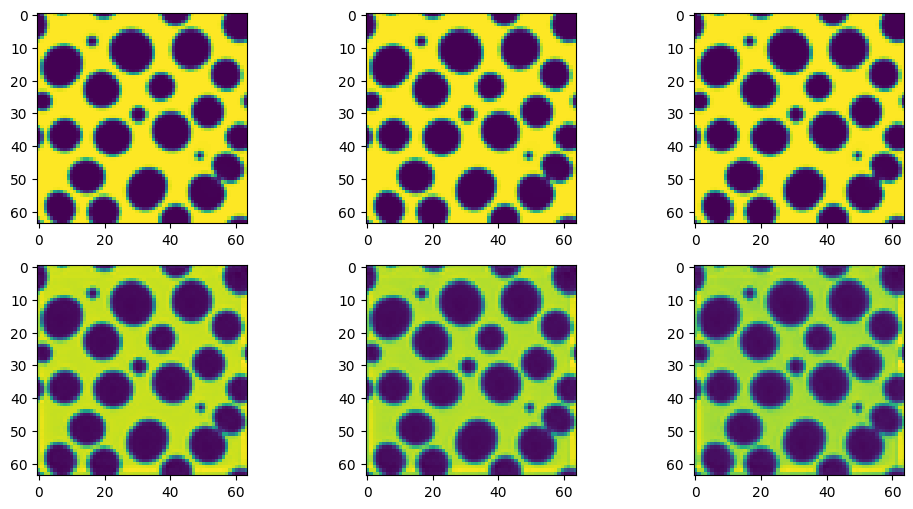

In [153]:
import matplotlib.pyplot as plt
f, ax = plt.subplot_mosaic('012;345', figsize=(12, 6))
ax['0'].imshow(y_g1[-1,3,:,:])
ax['1'].imshow(y_g2[-1,3,:,:])
ax['2'].imshow(y_g3[-1,3,:,:])

ax['3'].imshow(PD_G1[-1,3,:,:])
ax['4'].imshow(PD_G2[-1,3,:,:])
ax['5'].imshow(PD_G3[-1,3,:,:])

plt.show()